# Ex5. Regression

## 1. Set up

In [ ]:
!pip install sklearn emoji simpletransformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

import string
import re
import emoji
from textblob import TextBlob
from collections import Counter, OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import sklearn

import scipy

In [ ]:
# Check if device supports CUDA interface
CUDA = torch.cuda.is_available()
# Make program run on gpu (cuda:0) if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
torch.cuda.set_device(device)
print('Using device:', device)

Using device: cuda:0


In [ ]:
# Check and print information about available GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  4 15:02:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e8078ffe-143e-e8fd-ebf6-5cfc2a0156a8)


In [ ]:
# Check Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Generate the datasets

As we did in the previous excercise, we load and process the text using this class using the following steps:


> Remove html tags

> Convert all characters to lower case

> Remove all punctuation

> Convert all emojis to text

> Check for spelling mistakes

We use the 'Tweet' and 'Intensity Score' columns to generate the train and test dataset, in order to fit the requirement of "simpletransformer".



In [ ]:
class Dataset():
    # Initialise
    def __init__(self, train_file_path, test_file_path):
        self.train_file_path=train_file_path
        self.test_file_path=test_file_path
        self.train_df_full=None
        self.test_df_full=None
    
    # Load the data from the github project
    def load_data(self):
        train_df_full = pd.read_csv(self.train_file_path, sep='\t')
        self.train_df_full = train_df_full.rename(columns={"Tweet": "text", "Intensity Score": "labels"})
        test_df_full = pd.read_csv(self.test_file_path, sep='\t')
        self.test_df_full = test_df_full.rename(columns={"Tweet": "text", "Intensity Score": "labels"})
        
    
    # Text preprossesing functions

    # Remove any html tags
    def remove_html_tags(self, text):
        re_html = re.compile('<.*?>')
        return re_html.sub(r'', text)


    # Convert all characters to lower-case
    def convert_lowercase(self, text):
        return text.lower()

    # Remove all punctuation
    def remove_punc(self, text):
        x=''
        for i in range(len(text)):
            if text[i] in string.punctuation:
                if i!=0: 
                    if text[i-1]!=" ":
                        x=x+" "
            else:
                x=x+text[i]
        return x

    # Convert all emojis to text
    def convert_emoji(self, text):
        return emoji.demojize(text)
    
    # Check for any spelling mistakes
    def spelling_correction(self, text):
        textblob_ = TextBlob(text)
        return textblob_.correct().string
    
    # Apply the functions above
    def preprocessing(self, df):
        df=df.apply(self.remove_html_tags)
        df=df.apply(self.convert_lowercase)
        df=df.apply(self.convert_emoji)
        df=df.apply(self.remove_punc)
        #df=df.apply(self.spelling_correction)
        return df


    def generate_dataset(self):
        self.load_data()
        self.train_df_full['text'] = self.preprocessing(self.train_df_full['text'])
        self.test_df_full['text'] = self.preprocessing(self.test_df_full['text'])
        return self.train_df_full[['text','labels']], self.test_df_full[['text','labels']]
    def generate_raw_dataset(self):
        self.load_data()
        return self.train_df_full[['text','labels']], self.test_df_full[['text','labels']]


In [ ]:
train_file_path = '/content/drive/MyDrive/Colab Notebooks/ML4NLP/EX5/EI-reg-En-anger-train.txt'
test_file_path = '/content/drive/MyDrive/Colab Notebooks/ML4NLP/EX5/2018-EI-reg-En-anger-test-gold.txt'
dataset = Dataset(train_file_path, test_file_path)
train_df, test_df = dataset.generate_dataset()

In [ ]:
print('Number of train data: '+str(train_df.shape[0]))
print('Number of test data: '+str(test_df.shape[0]))

Number of train data: 1701
Number of test data: 1002


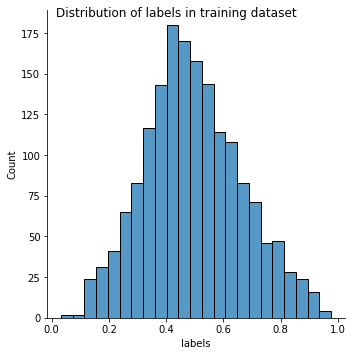

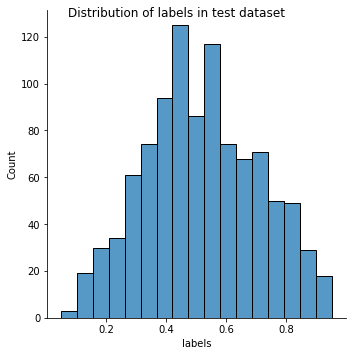

In [ ]:
plot_train = sns.displot(train_df,x='labels')
plot_train.fig.suptitle('Distribution of labels in training dataset')
plot_train.savefig("/content/drive/MyDrive/Colab Notebooks/ML4NLP/EX5/train_dis.png")
plot_test = sns.displot(test_df,x='labels')
plot_test.fig.suptitle('Distribution of labels in test dataset')
plot_test.savefig("/content/drive/MyDrive/Colab Notebooks/ML4NLP/EX5/test_dis.png")     

## 2. Model training and evaluation

In [ ]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Here we define the settings of our training model. We set the batch size to 32 to accelerate the training and try 10 epochs for each model.

In [ ]:
model_args = ClassificationArgs(
    num_train_epochs=10,
    overwrite_output_dir=True,
    use_early_stopping=True,
    weight_decay=0.0001,
    train_batch_size=64,
    regression=True
)

### 2.1 Model1: bert-base

BERT is a Transformer model pretrained on a large corpus of English data in a self-supervised fashion. This means it was pretrained on the raw texts only, with no humans labeling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts. 

In [ ]:
model1 = ClassificationModel(
    "bert",
    "bert-base-uncased",
    num_labels=1,
    args=model_args
)
model1.train_model(train_df, acc = scipy.stats.pearsonr)
result1, _, _ = model1.eval_model(test_df, acc = scipy.stats.pearsonr)
result1

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/1701 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': (0.7678786966591475, 1.258836145899418e-195),
 'eval_loss': 0.01475800622055041}

In [ ]:
result1_2, _, _ = model1.eval_model(test_df, acc = sklearn.metrics.r2_score)
result1_2

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': 0.5879800160835931, 'eval_loss': 0.01475800622055041}

### 2.2 Model2: roberta-base

This model is introduced in the paper by Liu et al. (2019). According to Liu et al. 2019, this model has improved upon prior models in the following four aspects:

>(1) training the model longer, with bigger batches,
over more data;

>(2) removing the next sentence
prediction objective;

>(3) training on longer sequences; and

>(4) dynamically changing the masking pattern applied to the training data.
They also collect a large new dataset (CC-NEWS) of comparable size to other privately used datasets, to better control for training set size effects.

In [ ]:
model2 = ClassificationModel(
    "roberta",
    "roberta-base",
    num_labels=1,
    args=model_args
)
model2.train_model(train_df, acc = scipy.stats.pearsonr)
result2, _, _ = model2.eval_model(test_df, acc = scipy.stats.pearsonr)
result2

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/1701 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': (0.8029073533472673, 6.5893597836425485e-227),
 'eval_loss': 0.013141429546983942}

In [ ]:
result2_2, _, _ = model2.eval_model(test_df, acc = sklearn.metrics.r2_score)
result2_2

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': 0.6322288274180787, 'eval_loss': 0.013141429546983942}

### 2.3 Model3: distilbert-base-uncased-finetuned-sst-2-english

This model is based on the DistilBERT base model, which is the distilled version of the BERT base model. It has been fine-tunned using the Stanford Sentiment Treebank(SST). The Stanford Sentiment Treebank consists of sentences from movie reviews and human annotations reagrding their sentiment. The task is to predict the sentiment of a given sentence. 

In [ ]:
model3 = ClassificationModel(
    "distilbert", 
    "distilbert-base-uncased-finetuned-sst-2-english",    
    args=model_args,
    num_labels=1,
    ignore_mismatched_sizes=True
)
model3.train_model(train_df, acc = scipy.stats.pearsonr)
result3, _, _ = model3.eval_model(test_df, acc = scipy.stats.pearsonr)
result3

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

  0%|          | 0/1701 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': (0.7372567868778989, 1.704556159789361e-172),
 'eval_loss': 0.016671005021115497}

In [ ]:
result3_2, _, _ = model3.eval_model(test_df, acc = sklearn.metrics.r2_score)
result3_2

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': 0.5331249485661679, 'eval_loss': 0.016671005021115497}

### 2.4 Model4: Twitter-roBERTa-base for Emotion Recognition

This is a roBERTa-base model trained on ~58M tweets and finetuned for emotion recognition with the TweetEval benchmark. We choose it because it's a model for emotion prediction, which should match our task. We noticed that this model supports unpreprocessed text so we used the raw tweets to train.

We noticed that this model may support unpreprocessed text. Then we tried to train this model with raw texts.

In [ ]:
data_raw = Dataset(train_file_path, test_file_path)
train_df_raw, test_df_raw = data_raw.generate_raw_dataset()
model4 = ClassificationModel(
    "roberta", 
    "cardiffnlp/twitter-roberta-base-emotion",    
    args=model_args,
    num_labels=1,
    ignore_mismatched_sizes=True
)
model4.train_model(train_df_raw, acc = scipy.stats.pearsonr)
result4, _, _ = model4.eval_model(test_df_raw, acc = scipy.stats.pearsonr)
result4

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1701 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': (0.8152503798591845, 1.7797838707944328e-239),
 'eval_loss': 0.012048244947523233}

In [ ]:
result4_2, _, _ = model4.eval_model(test_df_raw, acc = sklearn.metrics.r2_score)
result4_2

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': 0.6643758655037075, 'eval_loss': 0.012048244947523233}

The following is to attempts to achieve higher score.

In [ ]:
model_args2 = ClassificationArgs(
    num_train_epochs=20,
    overwrite_output_dir=True,
    use_early_stopping=True,
    learning_rate=4e-5,
    weight_decay=1e-4,
    train_batch_size=64,
    regression=True
)

data_raw = Dataset(train_file_path, test_file_path)
train_df_raw, test_df_raw = data_raw.generate_raw_dataset()
model5 = ClassificationModel(
    "roberta", 
    "cardiffnlp/twitter-roberta-base-emotion",    
    args=model_args2,
    num_labels=1,
    ignore_mismatched_sizes=True
)
model5.train_model(train_df_raw, acc = scipy.stats.pearsonr)
result5, _, _ = model5.eval_model(test_df_raw, acc = scipy.stats.pearsonr)
result5

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

  0%|          | 0/1701 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 0 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 1 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 2 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 3 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 4 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 5 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 6 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 7 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 8 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 9 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 10 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 11 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 12 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 13 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 14 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 15 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 16 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 17 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 18 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

Running Epoch 19 of 20:   0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': (0.8260151059384874, 3.1088260639193377e-251),
 'eval_loss': 0.01148468138472665}

In [ ]:
result5_2, _, _ = model5.eval_model(test_df_raw, acc = sklearn.metrics.r2_score)
result5_2

  0%|          | 0/1002 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

{'acc': 0.680508357356743, 'eval_loss': 0.01148468138472665}